# **Import Required Libraries** ⬇

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


In [3]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# **Load SST DataSet**

In [4]:
# Load the SST dataset
dataset = load_dataset('sst')

# Print keys in one example
print(dataset['train'][0].keys())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for sst contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sst
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

dict_keys(['sentence', 'label', 'tokens', 'tree'])


# **Mapping Sentences to 5 Classes**

In [5]:
# Map sentiment scores to classes
def map_sentiment_to_class(score):
    if score <= 0.2:
        return 0  # very negative
    elif score <= 0.4:
        return 1  # negative
    elif score <= 0.6:
        return 2  # neutral
    elif score <= 0.8:
        return 3  # positive
    else:
        return 4  # very positive

# Apply the mapping to the dataset
#dataset = dataset.map(lambda example: {'text': example['sentence'], 'label': map_sentiment_to_class(example['label'])})

# Split the dataset into training and testing sets
train_dataset = dataset['train']
test_data = dataset['test']

#from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
#train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)   #when splitting the dataset, it's better to use train_test_split or a similar function to ensure a random split

# Display the first few examples
print(train_dataset[0])
print(test_data[0])

{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 0.6944400072097778, 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.", 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}
{'sentence': 'Effective but too-tepid biopic', 'label': 0.5138900279998779, 'tokens': 'Effective|but|too-tepid|biopic', 'tree': '6|6|5|5|7|7|0'}


# **Features Extraction (Bi-Grams)**

In [6]:
# Function to tokenize a sentence into words
def tokenize(sentence):
    return sentence.split()

In [7]:
# Function to generate word bi-grams for a sentence
def generate_word_bigrams(sentence):
    words = tokenize(sentence)
    return [(words[i], words[i+1]) for i in range(len(words) - 1)]

In [10]:
# Function to generate word bi-gram features for the dataset
def generate_features(dataset):
    all_bigrams = set()
    for example in dataset:
        bigrams = generate_word_bigrams(example['sentence'])
        all_bigrams.update(bigrams)

    # Create a mapping of bi-grams to indices
    bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(all_bigrams)}

    # Create a feature matrix
    features = np.zeros((len(dataset), len(all_bigrams)))

    # Fill in the feature matrix
    for i, example in enumerate(dataset):
        bigrams = generate_word_bigrams(example['sentence'])
        for bi_gram in bigrams:
            index = bi_gram_to_index.get(bi_gram)
            if index is not None:
                features[i, index] = 1

    return features, bi_gram_to_index

In [11]:
# Generate word bi-gram features for training and testing sets
train_features, bi_gram_to_index = generate_features(train_dataset)
test_features, _ = generate_features(test_data)

# Display the shape of the feature matrices
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Train features shape: (8544, 87249)
Test features shape: (2210, 28231)


In [12]:
print(train_features)
print(train_features.dtype)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
float64


# **We need to convert it to int16 or int8 for memory optimization**

In [13]:
print(bi_gram_to_index)

{('hired', 'to'): 0, ('spans', 'time'): 1, ('years', 'after'): 2, ('awry', 'in'): 3, ('Mr.', 'Cantet'): 4, ('Bisset', 'delivers'): 5, ('about', 'America'): 6, ('to', 'investigate'): 7, ('he', 'falls'): 8, (',', 'Hoffman'): 9, ('starring', 'Ben'): 10, ('spectacular', 'belly'): 11, ('they', 'struggle'): 12, ('movie', 'season'): 13, ('was', 'inexplicably'): 14, ('political', 'edge'): 15, ('melodramatic', ','): 16, ('wordy', 'wisp'): 17, ('moving', ','): 18, ('first', 'lousy'): 19, ('Oprah', "'s"): 20, ('across', 'time'): 21, ('cat', "'s"): 22, ('families', 'in'): 23, ('paper', 'with'): 24, ('films', 'as'): 25, ('feel', 'enveloped'): 26, ('implosion', 'rather'): 27, ('their', 'budding'): 28, ('Carré', 'with'): 29, ('so', 'watchable'): 30, ('emphasizes', 'the'): 31, ('cameo-packed', ','): 32, ('represents', 'Adam'): 33, ('comprehend', 'it'): 34, (',', 'Crocodile'): 35, ('done', 'cinematically'): 36, ('abhorrent', '.'): 37, ('narrator', ','): 38, ('line', 'of'): 39, ('creepy', 'mood'): 40, (

# **Remove All Features in test set that doesn't appear in training features**

In [20]:
# Find common bi-grams between training and test sets
common_bigrams = set(bi_gram_to_index.keys()).intersection(set(_.keys()))
print("common_bigrams shape:", len(common_bigrams))

# Create a mapping of common bi-grams to indices
common_bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(common_bigrams)}

# Filter test features to keep only common bi-grams
test_features_filtered = np.zeros((test_features.shape[0], len(common_bigrams)))
for i, example in enumerate(test_data):
    bigrams = generate_word_bigrams(example['sentence'])
    for bi_gram in bigrams:
        if bi_gram in common_bigrams:
            index = common_bi_gram_to_index[bi_gram]
            test_features_filtered[i, index] = 1
# Add zero columns to test features to match the number of columns in training features
num_missing_columns = train_features.shape[1] - test_features_filtered.shape[1]
test_features_final = np.concatenate((test_features_filtered, np.zeros((test_features_filtered.shape[0], num_missing_columns))), axis=1)

# Display the shape of the final test features
print("Final test features shape:", test_features_final.shape)

common_bigrams shape: 10466
Final test features shape: (2210, 87249)


In [21]:
# Apply the mapping to the dataset and convert labels to integers
train_labels = np.array([map_sentiment_to_class(example['label']) for example in train_dataset])
test_labels = np.array([map_sentiment_to_class(example['label']) for example in test_data])

# **Model Implementation**

In [22]:
class Model1:
    def __init__(self, num_features, num_classes, learning_rate=0.01, num_epochs=100, batch_size=32):
        self.num_features = num_features
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = np.random.randn(num_features, num_classes)
        self.bias = np.zeros(num_classes)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def fit(self, X, y):
        for epoch in range(self.num_epochs):
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, len(X), self.batch_size):
                batch_X = X_shuffled[i:i+self.batch_size]
                batch_y = y_shuffled[i:i+self.batch_size]

                logits = np.dot(batch_X, self.weights) + self.bias
                probabilities = self.softmax(logits)

                one_hot_labels = np.eye(self.num_classes)[batch_y]
                loss = -np.mean(one_hot_labels * np.log(probabilities + 1e-10))

                gradient = probabilities - one_hot_labels
                weight_gradient = np.dot(batch_X.T, gradient)
                bias_gradient = np.sum(gradient, axis=0)

                self.weights -= self.learning_rate * weight_gradient
                self.bias -= self.learning_rate * bias_gradient

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        probabilities = self.softmax(logits)
        return np.argmax(probabilities, axis=1)

In [23]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class Model2:
    def __init__(self, num_classes):
        self.learning_rate = 0.01
        self.weights = None
        self.bias = None
        self.num_classes = num_classes

    def fit(self, X, y, epochs=100):
      n_samples, n_features = X.shape
      n_classes = self.num_classes

      self.weights = np.zeros((n_features, n_classes))
      self.bias = np.zeros(n_classes)

      for epoch in range(epochs):
          scores = np.dot(X, self.weights) + self.bias
          probabilities = softmax(scores)

          # One-hot encode the labels
          y_encoded = np.eye(n_classes)[y]

          # Compute the error
          error = probabilities - y_encoded

          # Compute gradients
          dw = (1 / n_samples) * np.dot(X.T, error)
          db = (1 / n_samples) * np.sum(error, axis=0)

          # Update weights and bias
          self.weights -= self.learning_rate * dw
          self.bias -= self.learning_rate * db


    def predict(self, X):
        scores = np.dot(X, self.weights) + self.bias
        probabilities = softmax(scores)
        return probabilities

# **Model training**

In [24]:
# Create an instance of the LogisticRegression class
model_1 = Model1(num_features=train_features.shape[1], num_classes=5)

# Fit the model on the training data
model_1.fit(train_features.astype(np.int8),train_labels.astype(np.int8))

In [25]:
# Initialize the logistic regression model
model_2 = Model2(num_classes=5)

# Fit the model on the training data
model_2.fit(train_features.astype(np.int8),train_labels.astype(np.int8))

# **Model testing**

In [26]:
# Make predictions on the padded test data
predictions_model_1 = model_1.predict(test_features_final.astype(np.int8))
print("Predictions:", predictions_model_1)

# Calculate the accuracy
accuracy_model_1 = np.mean(predictions_model_1 == test_labels)
print("Accuracy = ", accuracy_model_1*100,"%")

Predictions: [1 3 1 ... 1 0 2]
Accuracy =  20.85972850678733 %


In [27]:
# Make predictions on the padded test data
predictions_model_2 = model_2.predict(test_features_final.astype(np.int8))
print("Predictions:", predictions_model_2)

# Get the predicted classes
predicted_classes_model_2 = np.argmax(predictions_model_2, axis=1)
print("Predicted Classes:", predicted_classes_model_2)

# Calculate the accuracy
accuracy_model_2 = np.mean(predicted_classes_model_2 == test_labels)
print("Accuracy = ", accuracy_model_2*100,"%")

Predictions: [[0.18713646 0.21077643 0.19797408 0.21304981 0.19106323]
 [0.18714373 0.21077696 0.19795524 0.21309928 0.19102479]
 [0.18708085 0.21077543 0.19800249 0.21304729 0.19109394]
 ...
 [0.18713725 0.21077576 0.19797424 0.21304896 0.19106379]
 [0.18713227 0.21077141 0.19799269 0.21304471 0.19105892]
 [0.18713202 0.21079574 0.19796923 0.21304436 0.19105865]]
Predicted Classes: [3 3 3 ... 3 3 3]
Accuracy =  23.076923076923077 %


In [30]:
# Train scikit-learn's SGDClassifier
sgd_clf = SGDClassifier(loss='log', max_iter=100, tol=1e-3)
sgd_clf.fit(train_features.astype(np.int8), train_labels.astype(np.int8))
sgd_predictions = sgd_clf.predict(test_features_final)
sgd_accuracy = accuracy_score(test_labels, sgd_predictions)

# Train scikit-learn's LogisticRegression
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(train_features.astype(np.int8), train_labels.astype(np.int8))
lr_predictions = lr_clf.predict(test_features_final)
lr_accuracy = accuracy_score(test_labels, lr_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
print("My First Model accuracy:", accuracy_model_1*100, "%")
print("My Second Model accuracy:", accuracy_model_2*100, "%")
print("SGDClassifier accuracy:", sgd_accuracy*100, "%")
print("LogisticRegression accuracy:", lr_accuracy*100, "%")

My First Model accuracy: 20.85972850678733 %
My Second Model accuracy: 23.076923076923077 %
SGDClassifier accuracy: 24.07239819004525 %
LogisticRegression accuracy: 23.710407239819002 %


In [35]:
def compute_metrics(predictions, labels):
    confusion = confusion_matrix(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return confusion, precision, recall, f1, macro_precision, macro_recall, macro_f1

# Convert probabilities to class labels
my_predictions = predictions_model_1

# Compute metrics for your implementation
my_confusion, my_precision, my_recall, my_f1, my_macro_precision, my_macro_recall, my_macro_f1 = compute_metrics(my_predictions, test_labels)

# Convert probabilities from scikit-learn's SGDClassifier to class labels
# Reshape predictions to have two dimensions
sgd_predictions = sgd_predictions.reshape(-1, 1)

# Compute metrics for scikit-learn's SGDClassifier
sgd_confusion, sgd_precision, sgd_recall, sgd_f1, sgd_macro_precision, sgd_macro_recall, sgd_macro_f1 = compute_metrics(sgd_predictions, test_labels)

# Convert probabilities from scikit-learn's LogisticRegression to class labels
lr_predictions = lr_predictions.reshape(-1, 1)

# Compute metrics for scikit-learn's LogisticRegression
lr_confusion, lr_precision, lr_recall, lr_f1, lr_macro_precision, lr_macro_recall, lr_macro_f1 = compute_metrics(lr_predictions, test_labels)

In [36]:
def plot_confusion_matrix(confusion_matrix, labels, normalize=False):
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_matrix, annot=True, fmt=fmt, cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

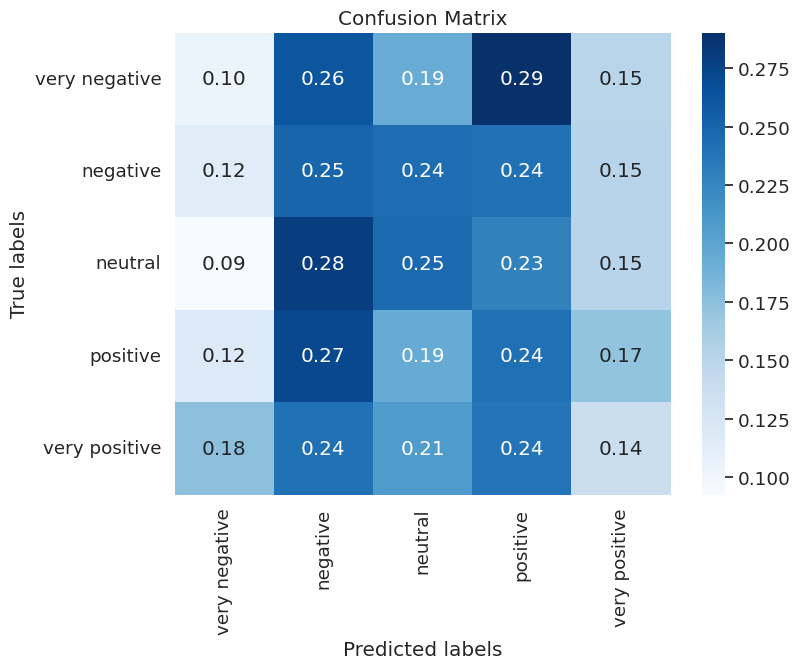

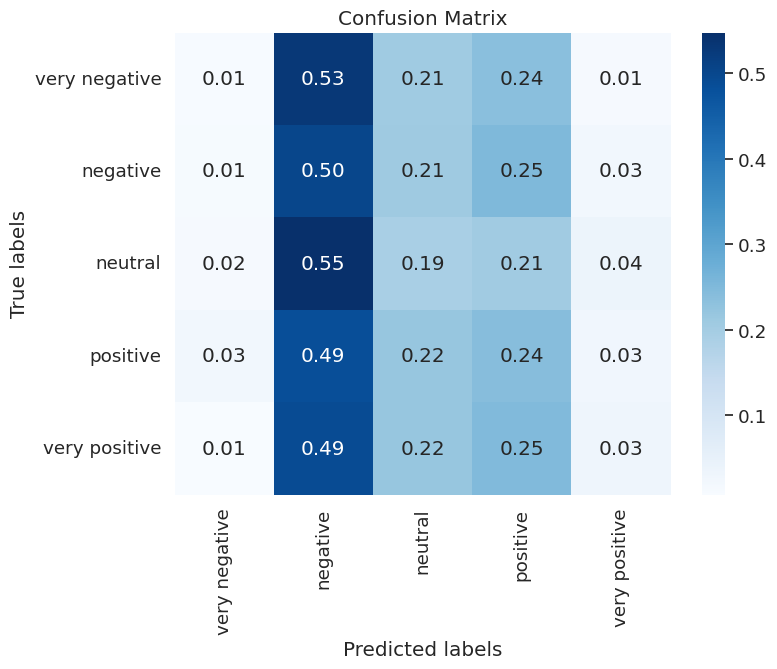

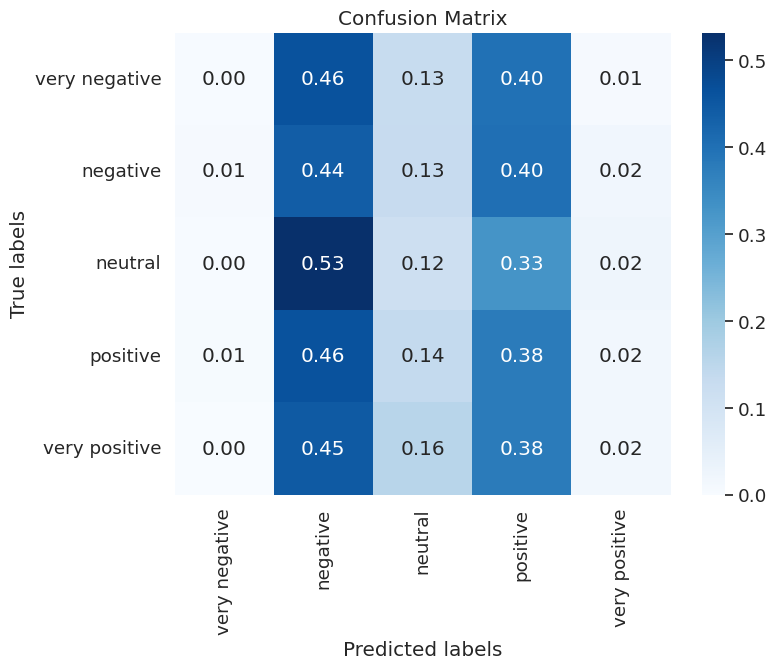

In [37]:
# Plot normalized confusion matrix for your implementation
plot_confusion_matrix(my_confusion, ['very negative', 'negative', 'neutral', 'positive', 'very positive'], normalize=True)

# Plot normalized confusion matrix for scikit-learn's SGDClassifier
plot_confusion_matrix(sgd_confusion, ['very negative', 'negative', 'neutral', 'positive', 'very positive'], normalize=True)

# Plot normalized confusion matrix for scikit-learn's LogisticRegression
plot_confusion_matrix(lr_confusion, ['very negative', 'negative', 'neutral', 'positive', 'very positive'], normalize=True)

In [39]:
print("Metrics for My Implementation:")
print("Precision:", my_precision)
print("Recall:", my_recall)
print("F1 Score:", my_f1)
print("Macro Precision:", my_macro_precision)
print("Macro Recall:", my_macro_recall)
print("Macro F1 Score:", my_macro_f1)

print("\nMetrics for scikit-learn's SGDClassifier:")
print("Precision:", sgd_precision)
print("Recall:", sgd_recall)
print("F1 Score:", sgd_f1)
print("Macro Precision:", sgd_macro_precision)
print("Macro Recall:", sgd_macro_recall)
print("Macro F1 Score:", sgd_macro_f1)

print("\nMetrics for scikit-learn's LogisticRegression:")
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)
print("Macro Precision:", lr_macro_precision)
print("Macro Recall:", lr_macro_recall)
print("Macro F1 Score:", lr_macro_f1)

Metrics for My Implementation:
Precision: [0.10780669 0.27478261 0.19753086 0.22777778 0.16176471]
Recall: [0.10394265 0.24960506 0.24678663 0.24117647 0.13784461]
F1 Score: [0.10583942 0.2615894  0.21942857 0.23428571 0.1488498 ]
Macro Precision: 0.19393252960062557
Macro Recall: 0.1958710844259622
Macro F1 Score: 0.19399858055383878

Metrics for scikit-learn's SGDClassifier:
Precision: [0.09090909 0.28317008 0.16129032 0.23339658 0.20967742]
Recall: [0.01075269 0.50236967 0.19280206 0.24117647 0.03258145]
F1 Score: [0.01923077 0.36218679 0.17564403 0.23722276 0.05639913]
Macro Precision: 0.1956886994854556
Macro Recall: 0.1959364674392158
Macro F1 Score: 0.17013669515307875

Metrics for scikit-learn's LogisticRegression:
Precision: [0.11111111 0.27042802 0.15151515 0.23058542 0.17948718]
Recall: [0.00358423 0.43917852 0.11568123 0.37843137 0.01754386]
F1 Score: [0.00694444 0.33473811 0.13119534 0.28656273 0.03196347]
Macro Precision: 0.18862537636229113
Macro Recall: 0.19088384210597